In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf
import tensorflow as tf
from pandas_datareader.yahoo.daily import YahooDailyReader
from stockstats import StockDataFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm


# Define the list of stock tickers and the date range
stock_tickers = ['OXY']#, 'GOOGL', 'MSFT']  # Replace with your list of stock tickers
start_date = '1994-01-01'  # Replace with your desired start date
end_date = '2023-09-17'  # Replace with your desired end date
# end_date = datetime.today()


def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append([target[i+target_size]])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multinew_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []   

    # start_index = start_index + history_size
    start_index = -history_size
    if end_index is None:
        end_index = len(dataset) 

    for i in range(start_index, end_index-target_size):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    return np.array(data)

def prediction_plot(history, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction[0])

    plt.plot(num_in, np.array(history), label='History')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction)[0], 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [228]:
# # Loop over each stock ticker
# # for ticker in stock_tickers:
# # Download stock price data using yfinance

[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

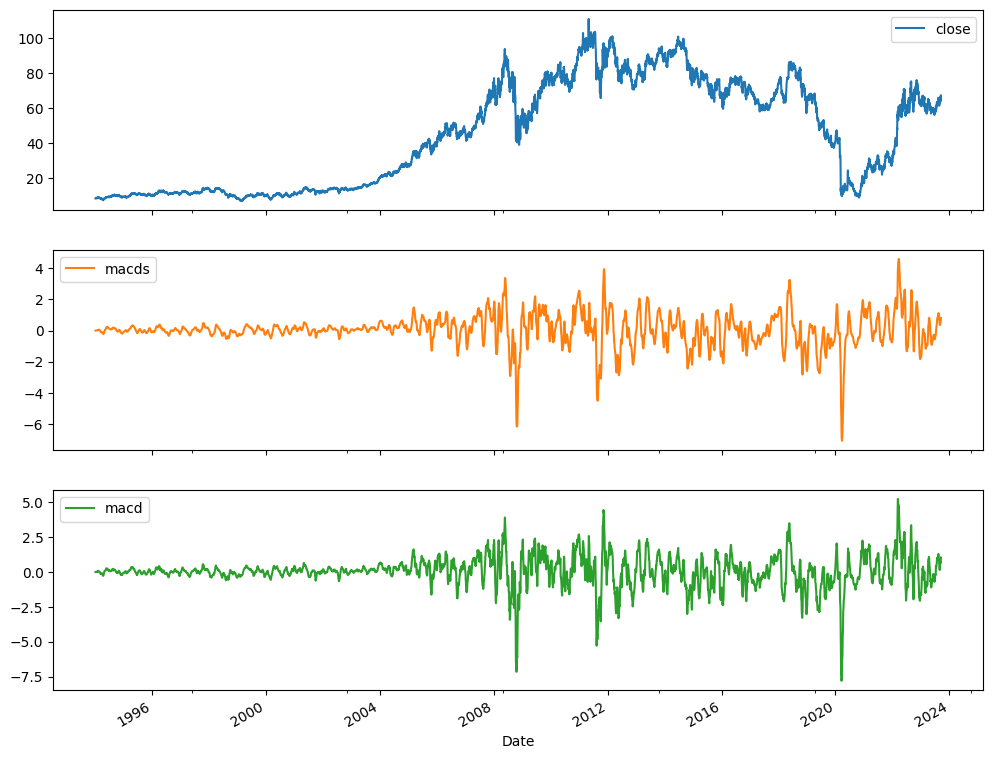

In [2]:
ticker = stock_tickers[0]

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
df = StockDataFrame.retype(df)
TRAIN_SPLIT = int(df.shape[0] * 0.8)
# df.head()

features_considered = ['close','macds','macd']
features = df[features_considered]
features.index = df.index
features.head()

features.plot(subplots=True,figsize=[12,10])

In [3]:
# Assuming your dataframe is called 'df' with columns 'column1', 'column2', 'column3'
columns_to_normalize = ['close', 'macds', 'macd']

# # Create an instance of MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler on the selected columns
# scaler.fit(features[columns_to_normalize])

# # Transform the selected columns using the scaler
# features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])

# dataset = features.values


dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std


pd.DataFrame(dataset, columns = features.columns, index = features.index).head()

,close,macds,macd
Date,,,
1994-01-03,-1.113246,-0.068929,-0.064807
1994-01-04,-1.115139,-0.069763,-0.066205
1994-01-05,-1.109459,-0.067653,-0.060793
1994-01-06,-1.105673,-0.064128,-0.053933
1994-01-07,-1.105673,-0.060962,-0.050434


In [4]:
past_history = 20
future_target = 5
STEP = 1

# Hyperparameters
BATCH_SIZE = 32
BUFFER_SIZE = 2000



x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)



#train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
#train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

#val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
#val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target price to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(5963, 20, 3)
(5963, 1)
Single window of past history : (20, 3)
Target price to predict : (1,)


In [243]:
# for x, y in val_data_multi.take(1):
#     multi_step_plot(x[0], y[0], np.array([0]))

In [5]:
# LSTM Parameters
EVALUATION_INTERVAL = 30 #len(x_train_multi)//batch_size//2 #15
VALIDATION_INTERVAL = 30 #len(x_val_multi)//batch_size//2
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)

In [83]:
# Split the data into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training, adjust as needed
train_data = dataset[:train_size]
test_data = dataset[train_size:]

# Separate the input (X_train) and output (y_train) variables for training
X_train = train_data[:-5]  # All but the last observation
y_train = train_data[5:]   # All but the first observation

X_train.shape,y_train.shape

((5978, 3), (5978, 3))

In [99]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = sm.tsa.VAR(y_train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    #print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -35.99382674319493

Order = 2
AIC:  -49.65289648013143

Order = 3
AIC:  -51.27688737362044

Order = 4
AIC:  -51.675909704399345

Order = 5
AIC:  -52.845788670915766

Order = 6
AIC:  -53.517356060571224

Order = 7
AIC:  -54.84035965549971

Order = 8
AIC:  -55.97097181635123

Order = 9
AIC:  -56.49731268629976

Order = 10
AIC:  -57.86020780132878



In [84]:
multi_step_model = sm.tsa.VAR(y_train)

result = multi_step_model.fit()

result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Oct, 2023
Time:                     17:26:54
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -35.9804
Nobs:                     5977.00    HQIC:                  -35.9892
Log likelihood:           82136.6    FPE:                2.33389e-16
AIC:                     -35.9938    Det(Omega_mle):     2.32921e-16
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000295         0.000434            0.678           0.498
L1.y1         0.999452         0.000435         2295.590           0.000
L1.y2         0.004349         0.001332            3.265           0.001
L1.y3        -0.005645

In [247]:
# plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [11]:
# history_df = pd.DataFrame(multi_step_history.history)
# history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
# history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [80]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

[0.6472197  0.64710169 0.64716027 0.64738796 0.64777629]
[0.64752068 0.63677021 0.61084263 0.5763779  0.56151693]


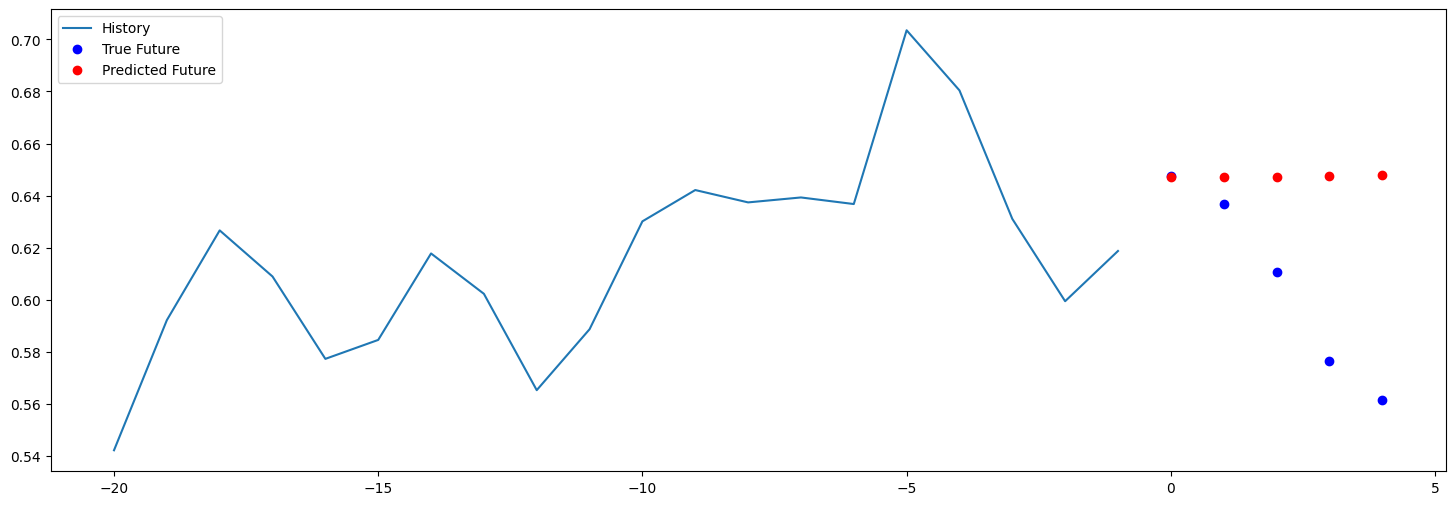

In [100]:
# Separate the input (X_test) and output (y_test) variables for evaluation
X_test = test_data[:-1]  # All but the last observation
y_test = test_data[1:]   # All but the first observation

print(result.forecast(y[-20:-19], steps=5)[:,0])
print(y[-20:-15][:,0])

multi_step_plot(y[-40:-20][:,0],y[-20:-15][:,0],result.forecast(y[-20:-19], steps=5)[:,0])
#y[-40:-20][:,0],y[-20:-15][:,0],result.forecast(y[-20:-19], steps=5)[:,0]

In [119]:
def new_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = 5

    plt.plot(num_in, np.array(history), label='History')
    #plt.plot(np.arange(num_out), np.array(true_future), 'bo',
    #    label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

[0.71105411 0.70894928 0.70698417 0.70516771 0.7035074 ]
[0.64024832 0.72214157 0.71866346 0.7496502  0.71328829]


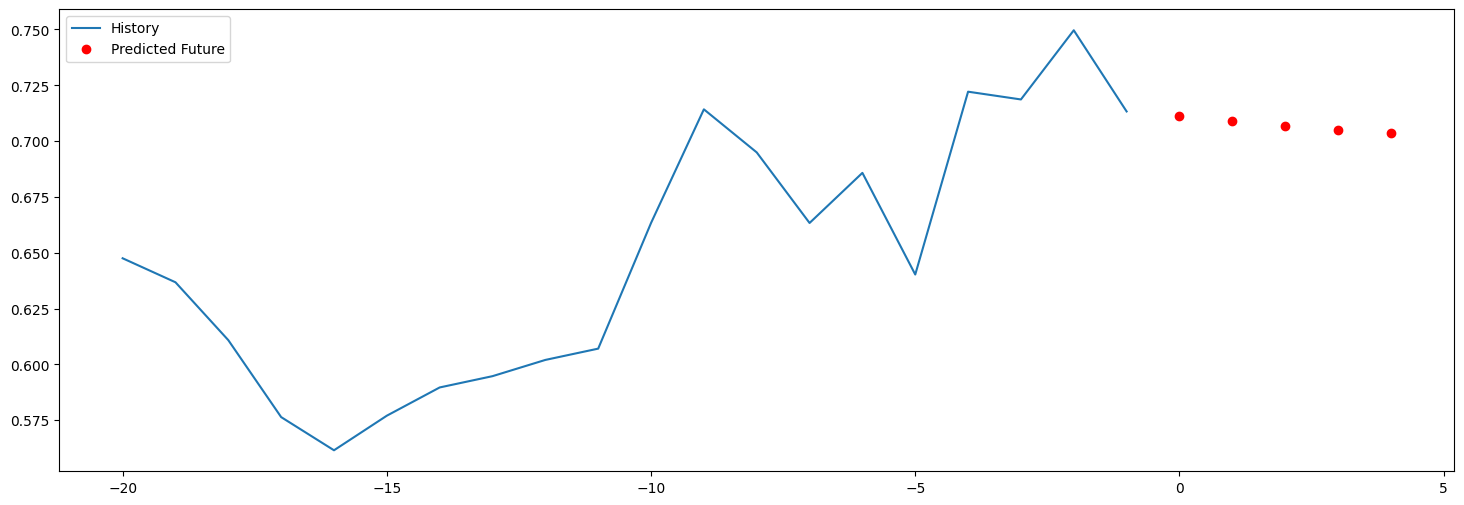

In [120]:
X_test = test_data[:-1]  # All but the last observation
y_test = test_data[1:]   # All but the first observation

print(result.forecast(y[-1:], steps=5)[:,0])
print(y[-5:][:,0])


y[-20:][:,0],result.forecast(y[-1:], steps=5)[:,0]
new_plot(y[-20:][:,0],None,result.forecast(y[-1:], steps=5)[:,0])

In [64]:
# New Predictions
#prediction_plot(x_new_multi[0][:,0], predictions_0)
prediction_plot(x_new_multi[-1][:,0], predictions_1)

TypeError: object of type 'numpy.float64' has no len()

<Figure size 1800x600 with 0 Axes>

In [ ]:
#  multi_step_model.save(f"model/model_{ticker}.h5")